In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import os
import gc
import sys
import h5py
import pickle
import numpy as np
import itertools as it
from tqdm.auto import trange,tqdm
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

import sys, os
sys.path.append(os.path.dirname(os.getcwd())+'/PDGNet')
from sysmodels import WirelessModel, patternnet
import utils 
from baselines import pa_orthog
from federated import *



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## load data

In [4]:

interf_scale = 1 # scale interference
i0 = 20 # which pmax

L = 8
n_ant = 10
M = 1
tr_dist = 'Alessio' # Alessio | HataSuburban | HataSuburban-noSF | HataUrban | HataUrban-noSF
te_dist = 'Alessio'

device = torch.device('cuda')

MODL_RT = "./results/]archive/models-nr10-pdg/"
DATA_RT = "/root/wireless-fl/data/"

####################################################
####################   DATA   ######################
####################################################

B = 1
m = 0.023
pdb = np.array(range(-40,10+1,1))
indexing = np.delete(np.arange(L**2), np.arange(L**2)[::L+1])

# add initial pt (max)
attach_pt = lambda x: torch.from_numpy(np.hstack((utils.init_p(x[:,-1], L, method="full"), x))).float().to(device)

# move channel info to device
dict_to_device = lambda x,dev: {k:v.to(dev) if isinstance(v, torch.Tensor) else v for k, v in x.items()}

X, y, cinfo = {},{},{}
for phase in ['tr','val','test']:
    sufix = '' if phase=='tr' else phase+'-'
    dfn = DATA_RT + f"bs+{M}_ant+{n_ant}/{sufix}channels-{tr_dist}-{L}-1000.h5" # train / validation data
    X[phase],y[phase],cinfo[phase] = utils.load_data_unsup(dfn, hxp=False, num_stab=1e-12, PdB=pdb)
    
    X[phase] = attach_pt(X[phase])
    X[phase][:,L:-1][:,indexing]*=interf_scale 
    
    cinfo[phase] = dict_to_device(cinfo[phase], device)
    print(phase, X[phase].shape, y[phase].shape)


ph = 'test'
H_mat = X[ph][i0::len(pdb),L:-1].cpu().numpy().reshape(-1,L,L) #* noise
p_max = X[ph][i0::len(pdb),-1].cpu().numpy().reshape(-1)
h_all = np.vstack([np.diag(H) for H in H_mat])
beta_all = np.array(H_mat) 
for bi, b in enumerate(beta_all):
    for i in range(b.shape[0]):
        beta_all[bi, i, i]=0
        

FINALERROR = {}
curr_task = 'MNIST' # AirQuality | MNIST

tr torch.Size([51000, 73]) (51000, 8)
val torch.Size([51000, 73]) (51000, 8)
test torch.Size([51000, 73]) (51000, 8)


## for mnist classification

In [12]:
if curr_task == 'MNIST':
    
    datanumber=(np.random.RandomState(42).randint(100,1000,L ) / 5).astype(int) #np.array([1000]*10)
    k_weights = datanumber/datanumber.sum()

    averagenumber = 3#10  ## Number of implementation of FL
    iteration     = 50  ## Number of iterations for each FL implementation

    numberofneuron = 50
    in_size        = 784
    out_size       = 10
    msize = in_size*numberofneuron + numberofneuron*out_size + (numberofneuron+out_size) #=39760
    Z = msize * 16 / 1024 / 1024    # Data size of each FL model, we assume that each element occupies 16 bits 
    sysmodel = WirelessModel(bandwidth=B)

    drequirement = Z / 0.7 ## delay requirement
    erequirement = Z / 55  ## energy requirement

    # MINST data processing
    batch_size_train = 16
    batch_size_test = 1000
         
    train_set, test_set = utils.load_mnist('./datasets/')


In [13]:
train_set

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./datasets/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
               Lambda()
           )

In [14]:
inputs = {
    'channels': (h_all, beta_all, p_max),
    'fedtask' : (test_set, train_set, batch_size_train),
    'require' : (drequirement, erequirement),
    'configs' : (numberofneuron, in_size, out_size), # fed network configs
}
datanumber.sum()

672

## ideal FL

In [15]:
FINALERROR['Ideal FL'], global_net, num_sel = FL_main(
    inputs        = inputs,
    fl_task       = curr_task,
    allocation_scheme = 'Ideal FL',
    usernumber    = L, 
    availnumber   = L,
    datanumber    = datanumber,
    iteration     = iteration, 
    averagenumber = averagenumber,
    seed          = 0
)

49 44 0.178 
Error at iter#50 is 0.17


49 37 0.178 
Error at iter#50 is 0.172


49 40 0.168 
Error at iter#50 is 0.162



## RAND POWER

In [16]:
FINALERROR['Rand'], global_net_rand, num_sel_rand = FL_main(
    inputs        = inputs,
    fl_task       = curr_task,
    allocation_scheme = 'Rand',
    usernumber    = L, 
    availnumber   = L,
    datanumber    = datanumber,
    iteration     = iteration, 
    averagenumber = averagenumber,
    seed          = 0
    )

49 44 0.215 
Error at iter#50 is 0.205


49 37 0.229 
Error at iter#50 is 0.201


49 40 0.278 
Error at iter#50 is 0.23



## ORTH POWER

In [17]:
FINALERROR['Orth'], _, num_sel_orth = FL_main(
     inputs        = inputs,
     fl_task       = curr_task,
     allocation_scheme = 'Orth',
     usernumber    = L, 
     availnumber   = L,
     datanumber    = datanumber,
     iteration     = iteration, 
     averagenumber = averagenumber,
     seed          = 0
)

49 44 0.238 
Error at iter#50 is 0.214


49 37 0.244 
Error at iter#50 is 0.209


49 40 0.217 
Error at iter#50 is 0.192



## MLP & GCN

In [19]:
def per_from_learning_models(modeldir, numworker):
    ## load model
    mfile = modeldir + 'model_pd.pt'
    mfilev = modeldir + 'model_pd-vio.pt'

    inputdir_test = {'Hx_dir':{'Hx':X['test'][i0::51, :], 
                               'edge_index':cinfo['test']['edge_index']}, 
                     'B':1, 'm':0.023}
    if os.path.exists(mfile):
        model = torch.load(mfile)
    else:
        model = torch.load(mfilev)
    model.eval()    
        
    # for compatibility
    model.model.net_size = numworker
    
    if 'GCN' in str(model.model.__class__):
        model.model.sig_size = 1
        for i, gconv in enumerate(model.model.model.hidden):
            #print(list(gconv.__dict__))
            if 'lin' not in gconv.__dict__:
                try:
                    w = gconv.weight
                except:
                    break
                gconv.lin = nn.Linear(*w.shape).to(w.device)
                with torch.no_grad():
                    gconv.lin.weight.copy_(w.T)

                gconv._explain = None
                gconv.decomposed_layers = 1

                # Hooks -- https://github.com/pyg-team/pytorch_geometric/blob/bc836242ab9c8c6fec96d5c6733a6df7aeb95802/torch_geometric/nn/conv/message_passing.py#L170
                gconv._propagate_forward_pre_hooks = {}
                gconv._propagate_forward_hooks = {}
                gconv._message_forward_pre_hooks = {}
                gconv._message_forward_hooks = {}
                gconv._aggregate_forward_pre_hooks = {}
                gconv._aggregate_forward_hooks = {}
                gconv._message_and_aggregate_forward_pre_hooks = {}
                gconv._message_and_aggregate_forward_hooks = {}
                gconv._edge_update_forward_pre_hooks = {}
                gconv._edge_update_forward_hooks = {}
        
    # allocate power
    with torch.no_grad():
        pt = model.allocate(inputdir_test['Hx_dir'])
    finalq = sysm.f1(pt, inputdir_test['Hx_dir']['Hx'], inputdir_test['m'])
    finalq_cond = (1-finalq*(pt>0)).cpu().numpy()   
    return finalq_cond
    

In [20]:
## MLP
modeldir = MODL_RT + f'Alessio_Ant+10_User+8_MLP_Intfx1_Pmax-20_Constr+c_seed+42/'

modeldir = './results2/models-nr10-uniformWeights-BpDaul/Alessio_Ant+10_User+8_MLP_Intfx1_Pmax-20_Constr+c+7.00e-01_e+5.50e+01_LR+1.0e-04_seed+42/'

finalq_mlp = per_from_learning_models(modeldir, L)

FINALERROR['PDM'], _, num_sel_mlp = FL_main(
    inputs        = inputs,
    fl_task       = curr_task,
    allocation_scheme = 'PD-MLP',
    usernumber    = L, 
    availnumber   = L,
    datanumber    = datanumber,
    iteration     = iteration, 
    averagenumber = averagenumber,
    per_ready     = finalq_mlp,
    seed          = 0
)


49 44 0.195 
Error at iter#50 is 0.188


49 37 0.242 
Error at iter#50 is 0.19


49 40 0.224 
Error at iter#50 is 0.179



## GCN

In [22]:
## GCN
modeldir = MODL_RT + f'Alessio_Ant+10_User+8_GCN_Intfx1_Pmax-20_Constr+c+e_LR+5.0e-04_seed+42/'

finalq_gcn = per_from_learning_models(modeldir, L)

FINALERROR['PDG'], _, num_sel_gcn = FL_main(
    inputs        = inputs,
    fl_task       = curr_task,
    allocation_scheme = 'PD-GCN',
    usernumber    = L, 
    availnumber   = L,
    datanumber    = datanumber,
    iteration     = iteration, 
    averagenumber = averagenumber,
    per_ready     = finalq_gcn,
    seed          = 0
)

49 44 0.177 
Error at iter#50 is 0.174


49 37 0.19  
Error at iter#50 is 0.169


49 40 0.172 
Error at iter#50 is 0.17



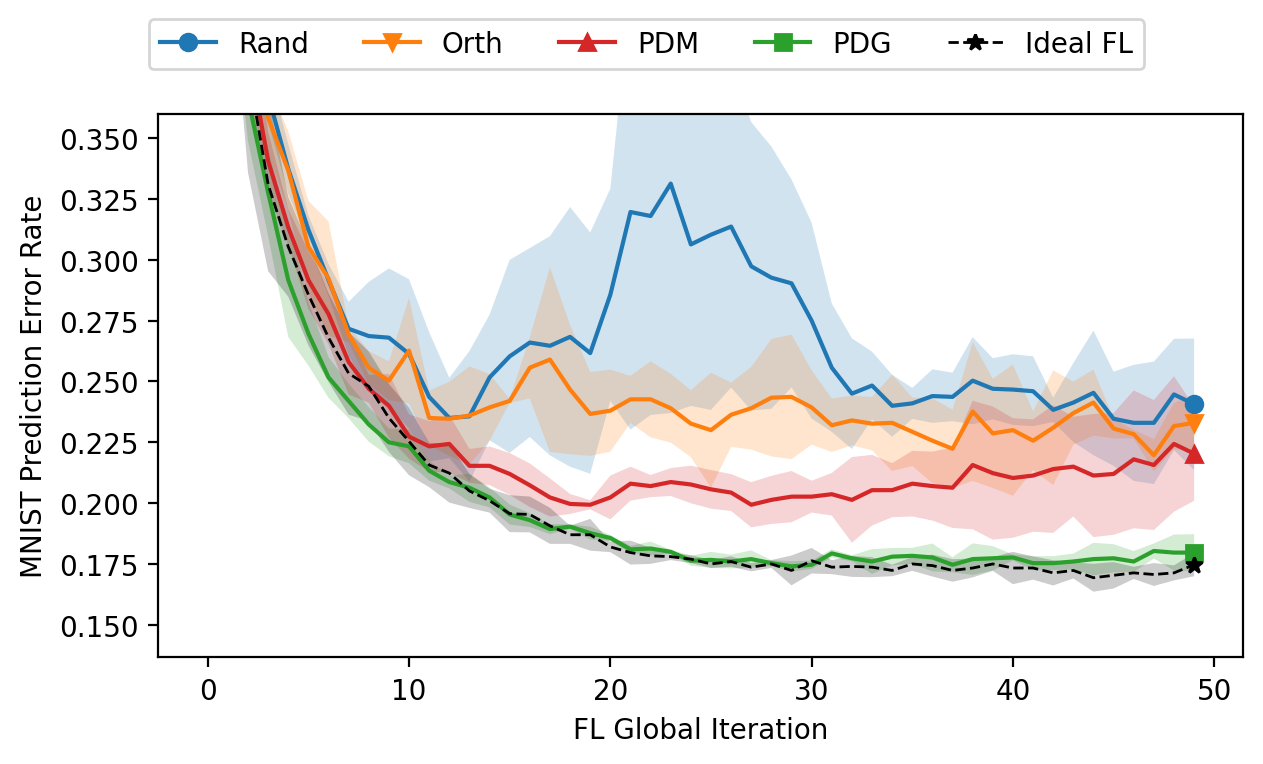

In [24]:
import matplotlib

[FINALERROR[k].sort(0) for k in FINALERROR.keys()]
if curr_task == 'MNIST':
    ylabel_string = 'MNIST Prediction Error Rate'
    max_scale = 1
    y_limits = None#[None, .36]#[.14, .36]
else:
    ylabel_string = 'Air Quality Prediction RMSE'
    max_scale = test_set.targets.max()
    y_limits = None#[None, 0.62]
ff = 10

pnames = ['Rand','Orth','PDG','PDM','Ideal FL']

fig, ax = plt.subplots(figsize=(7,4),dpi=200)
markercycle = it.cycle(('o','v','s','^','*','+','x')) 
for li, lab in enumerate(pnames):
    vals = FINALERROR[lab][:ff].mean(0)
    color = next(ax._get_lines.prop_cycler)['color']
    marker = next(markercycle)
    
    vv = vals[:50]/max_scale
    if li < len(pnames)-1:
        ax.plot(vv, markevery=[len(vv)-1], marker=marker, color=color, lw=1.5, label=lab)
    else:
        color = 'black'
        ax.plot(vv, ls='--', color=color, markevery=[len(vv)-1], marker=marker, lw=1, label=lab)
        
    # error shade
    ss = (FINALERROR[lab][:ff]/max_scale).std(0)[:50]
    plt.fill_between(range(len(vv)), vv-ss, vv+ss, alpha=0.2, edgecolor='none', facecolor=color)

# ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_ylim(y_limits)
plt.tick_params(axis='y', which='minor')
ax.yaxis.set_minor_formatter(matplotlib.ticker.FormatStrFormatter("%.1f"))

ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%d"))

ax.set_xlabel('FL Global Iteration')
ax.set_ylabel(ylabel_string)

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax.legend()
handles, labels = ax.get_legend_handles_labels()
# labels = ['Rand','Orth','PDGNet','PDF','Ideal FL']
labels = pnames
ax.legend([handles[0], handles[1], handles[3], handles[2], handles[4]], 
          [labels[0], labels[1], labels[3], labels[2], labels[4]],
         loc='upper center', bbox_to_anchor=(0.45, 1.2), ncol=5)

plt.ylim(None, 0.36)
plt.show()


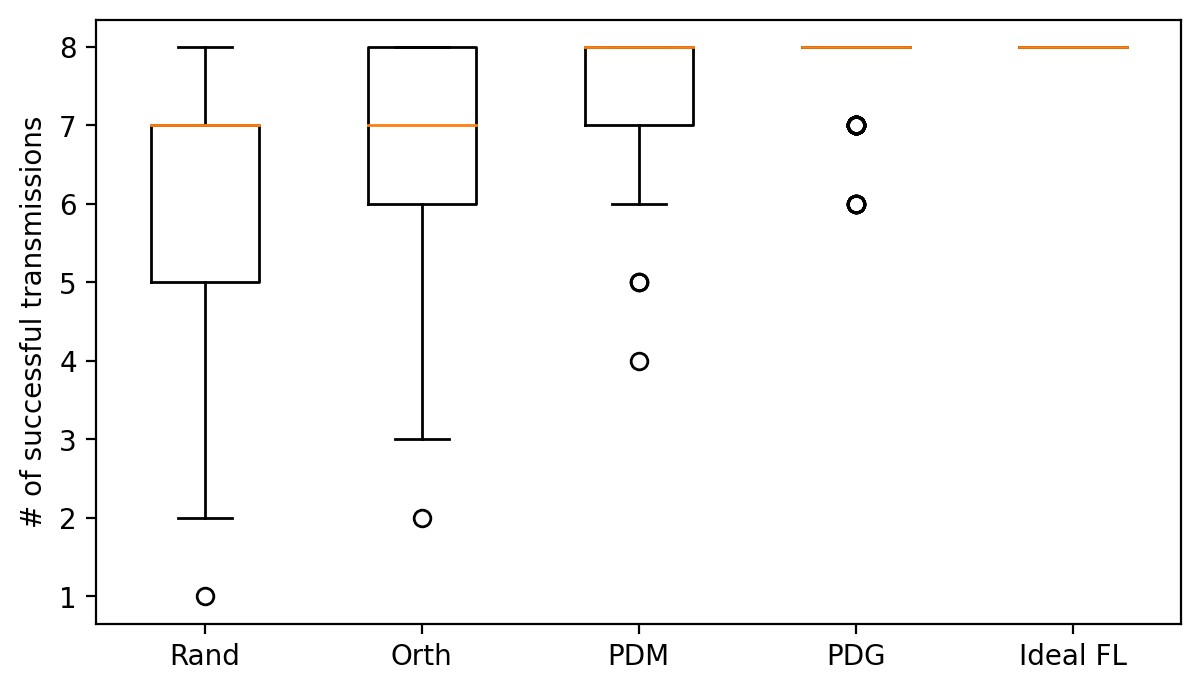

In [25]:
import pandas as pd
labels = ['Rand','Orth','PDM','PDG','Ideal FL']
num_sel_dict = dict(zip(['Rand','Orth','PDM','PDG','Ideal FL'], 
                        [d.sum(-1).flatten() for d in [num_sel_rand, num_sel_orth, num_sel_mlp, num_sel_gcn, num_sel]]))
df = pd.DataFrame.from_dict(num_sel_dict)

plt.figure(figsize=(7,4),dpi=200)
plt.boxplot(df[labels], labels=labels)
plt.ylabel("# of successful transmissions")
plt.show()